## DATA620 Final Project - Citibike Graph Network ##
**Measures of Centrality in the Citibike System**  

The Citibike system can be viewed as a highly connected directed graph with edges representing bicycle trips between stations. The trips are typically point-to-point and thus there are no network “flows” through the system. Usage and traffic varies greatly across the stations, depending on location and the seasons. Capacity planning (adding and removing nodes and bicycle stock) is a huge challenge for shared bicycle systems, particularly for Citibike, the largest in the U.S.

There a several approaches to capacity planning for systems like these, much coming from the field of operations research. From a basic perspective, two properties of the system must be considered: where to place stations and how many bicycles are needed to meet demand. Measure of centrality between stations can be used to discover potential bottlenecks (i.e. stations depleted of bicycles vs. stations filled to capacity) and suggest future placement of new stations.

I will not address tricky operational strategies for this project. Rather, I will analyze a graph generated from Citibike data and see what it tells us about centrality and bicycle traffic for the system.  
  
Citibike system data is availble here: https://www.citibikenyc.com/system-data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Citibike system data is made available in monthly archives. I'm using data from April, 2016. Results would vary greatly for other months.

In [292]:
trips = pd.read_csv("201604-citibike-tripdata.csv", dtype={'start station id':str, 'end station id':str})

In [101]:
# UTILITY FUNCTIONS

def sorted_map(map):
    ms = sorted(map.iteritems(),key=lambda(k,v):(-v,k))
    return ms

# RETURNS NODES ABOVE OR BELOW A THRESHHOLD
def subgraph_bydeg(g, cut, op='>', w=''):
    nodes = []
    for n in g:
        if op == '>':
            if nx.degree(g, n, weight=w)> cut: nodes.append(n)
        else:
            if nx.degree(g, n, weight=w)< cut: nodes.append(n)
    return nodes


I'm using only *start station id*, *end station id,* and *start station name* columns. Although trips have direction, the resulting graph will be undirected.

In [293]:
trips.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,496,4/1/2016 00:00:26,4/1/2016 00:08:42,254,W 11 St & 6 Ave,40.735324,-73.998004,236,St Marks Pl & 2 Ave,40.728419,-73.987140,19704,Subscriber,1984.0,1
1,104,4/1/2016 00:00:27,4/1/2016 00:02:12,311,Norfolk St & Broome St,40.717227,-73.988021,350,Clinton St & Grand St,40.715595,-73.987030,21555,Subscriber,1970.0,1
2,128,4/1/2016 00:00:30,4/1/2016 00:02:38,3064,Myrtle Ave & Lewis Ave,40.696820,-73.937569,3059,Pulaski St & Marcus Garvey Blvd,40.693398,-73.939877,17430,Subscriber,1986.0,1
3,1197,4/1/2016 00:00:34,4/1/2016 00:20:31,3156,E 72 St & York Ave,40.766638,-73.953483,490,8 Ave & W 33 St,40.751551,-73.993934,17413,Subscriber,1981.0,1
4,419,4/1/2016 00:00:46,4/1/2016 00:07:46,116,W 17 St & 8 Ave,40.741776,-74.001497,405,Washington St & Gansevoort St,40.739323,-74.008119,16714,Subscriber,1982.0,2


In [294]:
 # REMOVE SELF LOOPS (TRIPS WITH SAME START/END ID)
trips = trips[trips['start station id']!=trips['end station id']]

Let's have a quick view into station traffic. First, stations with the most departures.

In [295]:
sta_groups = trips.groupby(['start station name'], sort=0)
counts = sta_groups['start station name'].count()
deps = pd.DataFrame(counts)
deps.columns=['departures']
deps.sort_values('departures', ascending=0)[:10]

,departures
start station name,
Pershing Square North,11525
Broadway & E 22 St,7796
W 21 St & 6 Ave,7745
E 17 St & Broadway,7654
Lafayette St & E 8 St,7619
West St & Chambers St,7511
W 20 St & 11 Ave,6247
Carmine St & 6 Ave,6200
Greenwich Ave & 8 Ave,6178


The top two starting points are Madison Square Park and Grand Central Station. This changes based on the season, but Grand Central is always near the top.  

Now, the top ten arrival points.

In [296]:
end_groups = trips.groupby(['end station name'], sort=0)
counts = end_groups['end station name'].count()
arrs = pd.DataFrame(counts)
arrs.columns=['arrivals']
arrs.sort_values('arrivals', ascending=0)[:10]

,arrivals
end station name,
Pershing Square North,11245
Lafayette St & E 8 St,8010
E 17 St & Broadway,7913
W 21 St & 6 Ave,7782
West St & Chambers St,7663
Broadway & E 22 St,7443
W 20 St & 11 Ave,6683
Carmine St & 6 Ave,6376
Broadway & E 14 St,6294


Riders are heading to Grand Central, the Union Square area, and NYU territory. Where are riders going the least?

In [297]:
arrs.sort_values('arrivals', ascending=1)[:10]

,arrivals
end station name,
Paulus Hook,1
Heights Elevator,1
SSP Tech Workshop,1
Hilltop,1
Essex Light Rail,3
Marcy Ave & MacDonough St,20
NYCBS Depot - DEL,21
NYCBS Depot BAL - DYR,23
NYCBS Depot - PIT,30


The loneliest destinations appear to be in Jersey City. Now I create the basic graph from the dataset.

In [298]:
# create system graph
p = nx.from_pandas_dataframe(trips, 'start station id','end station id')

Then generate the list of station names.

In [299]:
idn = trips.drop_duplicates('start station id')
names = dict(zip(idn['start station id'],idn['start station name']))

Prepare the edge weight and node name attributes. The edge weights are generated by adding  undirected edges (trips) between nodes and incrementing the edge weight.

In [300]:
nx.set_edge_attributes(p, 'weight',0)
nx.set_node_attributes(p, 'name', names)

In [301]:
for i, row in trips.iterrows():
    sn, en = row['start station id'], row['end station id']
    p[sn][en]['weight'] +=1


# p = nx.read_gml("p.gml")

In [303]:
# nx.write_gml(p, "p.gml") # save graph to disk

In [302]:
print nx.info(p)

Name: 
Type: Graph
Number of nodes: 483
Number of edges: 59969
Average degree: 248.3188


That's a lot of edges. There's no point to drawing this graph completely; it's too dense.  

Now I can examine the node degree centrality. Listing the top ten:

In [304]:
pdc = nx.degree_centrality(p)
top10cent = sorted_map(pdc)[:10]
for k,v in top10cent:
    print "%s: %s" % (v, names[k])

0.852697095436: Cleveland Pl & Spring St
0.823651452282: Rivington St & Chrystie St
0.815352697095: Mott St & Prince St
0.813278008299: Great Jones St
0.813278008299: Lafayette St & Jersey St
0.809128630705: Lafayette St & E 8 St
0.809128630705: Suffolk St & Stanton St
0.798755186722: Broadway & E 14 St
0.798755186722: S 5 Pl & S 4 St
0.794605809129: Stanton St & Chrystie St


Note that not all of the top ten departure stations are among the top ten centrality stations. This shows that centrality and trip frequency are not necessarily in a linear relationship.  

Without visualizing the network, let's examine the distribtion of node degree and node weight. Node weight in this context is the sum of all connected edge weights, thus the total number of trips to and from that node.

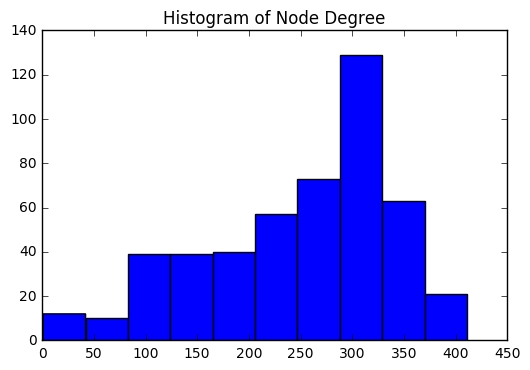

In [305]:
deg = nx.degree(p)
plt.hist(deg.values())
plt.title('Histogram of Node Degree')
plt.show()

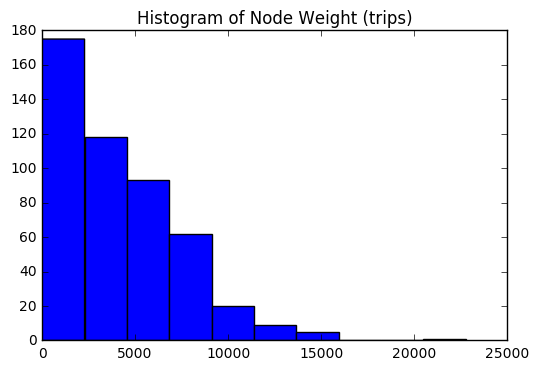

In [306]:
plt.hist(nx.degree(p, weight='weight').values())
plt.title('Histogram of Node Weight (trips)')
plt.show()

Both histograms are highly skewed. We can infer from the first histogram that the graph is highly connected without visualizing it. It's close to a mesh network.

In [307]:
# COMPUTE AVERAGES
d_byedge = nx.degree(p)
d_byweight = nx.degree(p, weight='weight')

In [308]:
e_avg = np.mean([k for k in d_byedge.values()])
w_avg = np.mean([k for k in d_byweight.values()])
print ("avg node weight: %d" % w_avg)

avg node weight: 4112


With two basic metrics for each node, degree centrality and weight, and their means for the entire graph, I can classify each node into one of four categories: above-average centrality/above-average weight, below-average centrality/below-average weight, above-average centrality/below-average weight, and below-average centrality/above-average weight. I will do this by dividing nodes into two disjoint sets, then finding their respective intersections.

In [309]:
aac = subgraph_bydeg(p, e_avg, op='>', w='') # above-average centrality, etc.
bac = subgraph_bydeg(p, e_avg, op='<', w='')
aaw = subgraph_bydeg(p, w_avg, op='>', w='weight')
baw = subgraph_bydeg(p, w_avg, op='<', w='weight')
print len(aac)
print len(bac)
print len(aaw)
print len(baw)


283
200
204
279


Find their intersections.

In [310]:
aac_aaw = list(set(aac) & set(aaw))
aac_baw = list(set(aac) & set(baw))
bac_aaw = list(set(bac) & set(aaw))
bac_baw = list(set(bac) & set(baw))
print len(aac_aaw)
print len(aac_baw)
print len(bac_aaw)
print len(bac_baw)

202
81
2
198


aac_aaw and bac_baw are very close.  

bac_aaw has only two members:

In [323]:
for k in bac_aaw:
    print names[k]
    
print nx.degree(p,bac_aaw)
print nx.degree(p,bac_aaw, weight='weight')

5 Ave & E 73 St
Central Park West & W 72 St
{'3137': 239, '3165': 239}
{'3137': 5805, '3165': 5443}


*aac_baw* is not too dense to visualize:

In [313]:
g = p.subgraph(aac_baw)

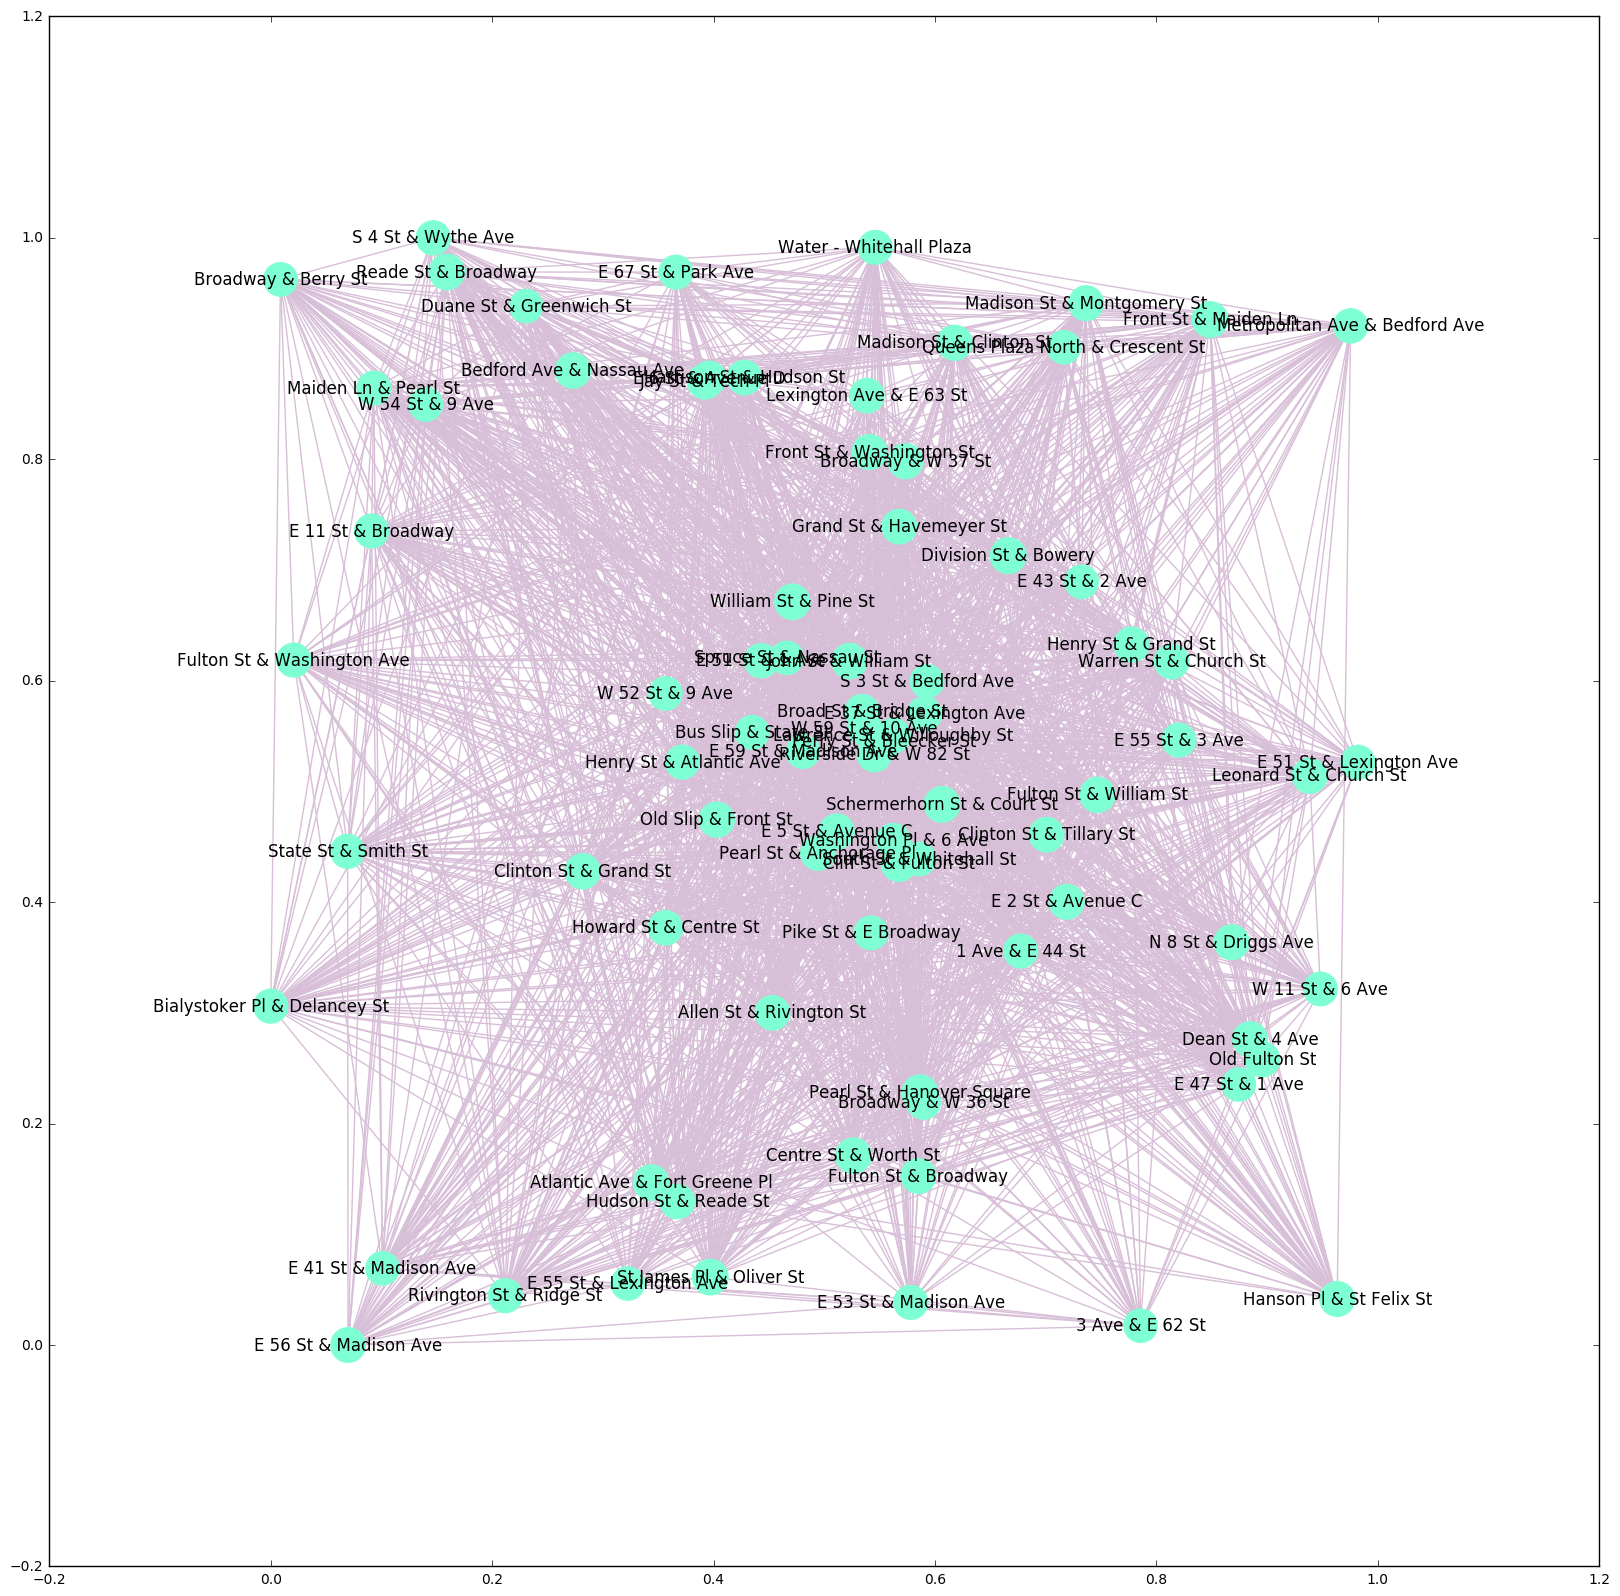

In [315]:
labels = dict((n, d['name']) for n,d in g.nodes(data=True))
byedge = nx.degree(g)
byweight = nx.degree(g, weight='weight')
nsizes = [k for k in byweight.values()]
nsizes = map(lambda x: x/10 + 600, nsizes)

plt.figure(figsize = (20,20))
nx.draw_networkx(g, pos=nx.spring_layout(g, iterations=1), labels=labels, node_size=nsizes, linewidths=0, node_color='aquamarine',edge_color='thistle')
#plt.show()

**Conclusion**

When considering the meaning of the four node categories I’ve described, only those nodes with properties significantly above or below the mean are of interest.

For AAC/AAW, these nodes are the hot spots. Lots of bicyclists are arriving from or departing to a large portion of the system. For capacity planning, those nodes are potential bottlenecks.  

For BAC/BAW, the outliers here are underused and could be targets for consolidation or even removal.

For BAC/AAW, the two nodes classified by my method do seem to explain this property well. They both flank opposite ends of Central Park and are thus away from the denser parts of the Citibike network, and are likely heavily used by park-goers and tourists looking to take a nice ride through the park throughout the day. Any two nodes (or two groups of nodes) that exchange regular traffic would belong to bac_aaw.

AAC/BAW is harder to explain without further trip analysis.  These could be nodes that get the “run off” from other weightier nodes, due to riders being blocked by full stations or depleted ones. They also might cater to the random nature of trips that don’t adhere to regular commuter schedules and pathways through the city.
